# 대회 개요
* Playground 대회
* 실제 데이터를 바탕으로 합성 데이터를 제공
* 제공된 feature를 바탕으로 소프트웨어 결함 여부를 검출
# 대회 기간
* 시작일 23/10/03
* 종료일 23/10/23
# 평가 지표
* area under the ROC curve
    * `from sklearn.metrics import roc_auc_score`
# 데이터 요약
* feature
    * int와 float형태의 22개의 feature를 제공함
* target
    * defects를 나타내는 boolean 값
        * 결함이 있으면 True
        * 결함이 없으면 False
* feature 정리
    ```
    1. loc              : numeric % McCabe's line count of code
    2. v(g)             : numeric % McCabe "cyclomatic complexity"
    3. ev(g)            : numeric % McCabe "essential complexity"
    4. iv(g)            : numeric % McCabe "design complexity"
    5. n                : numeric % Halstead total operators + operands
    6. v                : numeric % Halstead "volume"
    7. l                : numeric % Halstead "program length"
    8. d                : numeric % Halstead "difficulty"
    9. i                : numeric % Halstead "intelligence"
    10. e               : numeric % Halstead "effort"
    11. b               : numeric % Halstead
    12. t               : numeric % Halstead's time estimator
    13. lOCode          : numeric % Halstead's line count
    14. lOComment       : numeric % Halstead's count of lines of comments
    15. lOBlank         : numeric % Halstead's count of blank lines
    16. lOCodeAndComment: numeric
    17. uniq_Op         : numeric % unique operators
    18. uniq_Opnd       : numeric % unique operands
    19. total_Op        : numeric % total operators
    20. total_Opnd      : numeric % total operands
    21: branchCount     : numeric % of the flow graph
    22. defects         : {false,true} % module has/has not one or more  reported defects
    ```

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib import gridspec

In [52]:
# 데이터 둘러보기

In [53]:
data_path = '../../data/'

train_df = pd.read_csv(data_path+'train.csv', index_col='id')
test_df = pd.read_csv(data_path+'test.csv', index_col='id')
submission_df = pd.read_csv(data_path+'sample_submission.csv', index_col='id')
train_origin_df = train_df.copy()
test_origin_df = test_df.copy()

In [54]:
# majority class를 minority class의 개수에 맞춰서 downsampling
def downsampling(df):
    df_0 = df[df.defects == 0] # majority class
    df_1 = df[df.defects == 1] # minority class

    idx = list(range(len(df_0)))
    np.random.seed(61)
    np.random.shuffle(idx)
    idx_down = idx[:len(df_1)*2]
    return pd.concat([df_0.iloc[idx_down], df_1])

# train_df = downsampling(train_df).reset_index(drop=True)
# train_df.defects.value_counts()

In [55]:
def outlier_score(df, feature, iqr_weight=1.5):
    s_df = df[feature] * 1
    q1 = s_df.quantile(0.25)
    q3 = s_df.quantile(0.75)
    iqr = q3-q1
    return q3+iqr_weight*iqr

In [56]:
# 데이터 요약
def resume_table(df):
    summary_df = df.dtypes
    df = df * 1 # defects를 int형으로 바꾸기
    summary_df = summary_df.reset_index()
    summary_df.columns = ['Column', 'Dtypes']
    summary_df['결측치'] = df.isnull().sum().values
    summary_df['유니크개수'] = df.nunique().values
    summary_df['평균'] = df.describe().loc['mean'].values
    summary_df['std'] = df.describe().loc['std'].values
    summary_df['min'] = df.describe().loc['min'].values
    summary_df['median'] = df.describe().loc['50%'].values
    summary_df['max'] = df.describe().loc['max'].values
    summary_df['outlier'] = [outlier_score(df, c) for c in df.columns]
    return summary_df.set_index('Column')

resume_table(train_df)

,Dtypes,결측치,유니크개수,평균,std,min,median,max,outlier
Column,,,,,,,,,
loc,float64,0,378,37.347160,54.600401,1.0,22.00,3442.00,85.500
v(g),float64,0,106,5.492684,7.900855,1.0,3.00,404.00,12.000
ev(g),float64,0,71,2.845022,4.631262,1.0,1.00,165.00,6.000
iv(g),float64,0,84,3.498826,5.534541,1.0,2.00,402.00,8.500
n,float64,0,836,96.655995,171.147191,0.0,51.00,8441.00,240.000
v,float64,0,4515,538.280956,1270.791601,0.0,232.79,80843.08,1254.120
l,float64,0,55,0.111634,0.100096,0.0,0.09,1.00,0.300
d,float64,0,3360,13.681881,14.121306,0.0,9.82,418.20,36.600
i,float64,0,5171,27.573007,22.856742,0.0,23.36,569.78,62.510


# vif

In [57]:
def vif(x, thresh=10):
    # vif 10 초과시 drop을 위한 임계값 설정
    # Filter method로 feature selection 진행 후 최종 도출 될 데이터 프레임 형성
    output = pd.DataFrame(columns=x.columns)
    # 데이터의 컬럼 개수 설정
    k = x.shape[1]
    # VIF 측정
    output_columns = x.columns
    vif = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
    removal_columns = []
    for i in range(1,k):
        print(f'{i}번째 VIF 측정')
        # VIF 최대 값 선정
        a = np.argmax(vif)
        print(f'Max VIF feature & value : {output.columns[a]}, {vif[a]}')
        # VIF 최대 값이 임계치를 넘지 않는 경우 break
        if (vif[a] <= thresh):
            print('\n')
            for q in range(output.shape[1]):
                print(f'{output.columns[q]}의 vif는 {np.round(vif[q],2)}입니다.')
            break
        # VIF 최대 값이 임계치를 넘는 경우, + 1번째 시도인 경우 : if 문으로 해당 feature 제거 후 다시 vif 측정
        if (i == 1):
            removal_columns.append(output_columns[a])
            output = x.drop(output_columns[a], axis = 1)
            output_columns = output.columns
            vif = [variance_inflation_factor(output.values, j) for j in range(output.shape[1])]
        # VIF 최대 값이 임계치를 넘는 경우, + 1번째 이후 시도인 경우 : if 문으로 해당 feature 제거 후 다시 vif 측정
        elif (i > 1):
            removal_columns.append(output_columns[a])
            output = output.drop(output_columns[a], axis = 1)
            output_columns = output.columns
            vif = [variance_inflation_factor(output.values, j) for j in range(output.shape[1])]
    return output, removal_columns

In [58]:
X = train_df.drop(columns='defects')
vif_df, removal_columns = vif(X, 20)

1번째 VIF 측정
Max VIF feature & value : branchCount, 30.62102382338447
2번째 VIF 측정
Max VIF feature & value : total_Opnd, 28.71076448015364
3번째 VIF 측정
Max VIF feature & value : total_Op, 24.843521854143706
4번째 VIF 측정
Max VIF feature & value : n, 17.760236849351767


loc의 vif는 6.67입니다.
v(g)의 vif는 8.11입니다.
ev(g)의 vif는 3.16입니다.
iv(g)의 vif는 4.42입니다.
n의 vif는 17.76입니다.
v의 vif는 13.71입니다.
l의 vif는 1.82입니다.
d의 vif는 11.1입니다.
i의 vif는 8.96입니다.
e의 vif는 3.15입니다.
b의 vif는 12.47입니다.
t의 vif는 3.19입니다.
lOCode의 vif는 13.05입니다.
lOComment의 vif는 1.79입니다.
lOBlank의 vif는 4.53입니다.
locCodeAndComment의 vif는 1.16입니다.
uniq_Op의 vif는 11.07입니다.
uniq_Opnd의 vif는 10.13입니다.


In [59]:
removal_columns

['branchCount', 'total_Opnd', 'total_Op']

In [60]:
vif_df.columns

Index(['loc', 'v(g)', 'ev(g)', 'iv(g)', 'n', 'v', 'l', 'd', 'i', 'e', 'b', 't',
       'lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment', 'uniq_Op',
       'uniq_Opnd'],
      dtype='object')

In [61]:
train_origin_df.columns

Index(['loc', 'v(g)', 'ev(g)', 'iv(g)', 'n', 'v', 'l', 'd', 'i', 'e', 'b', 't',
       'lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment', 'uniq_Op',
       'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount', 'defects'],
      dtype='object')

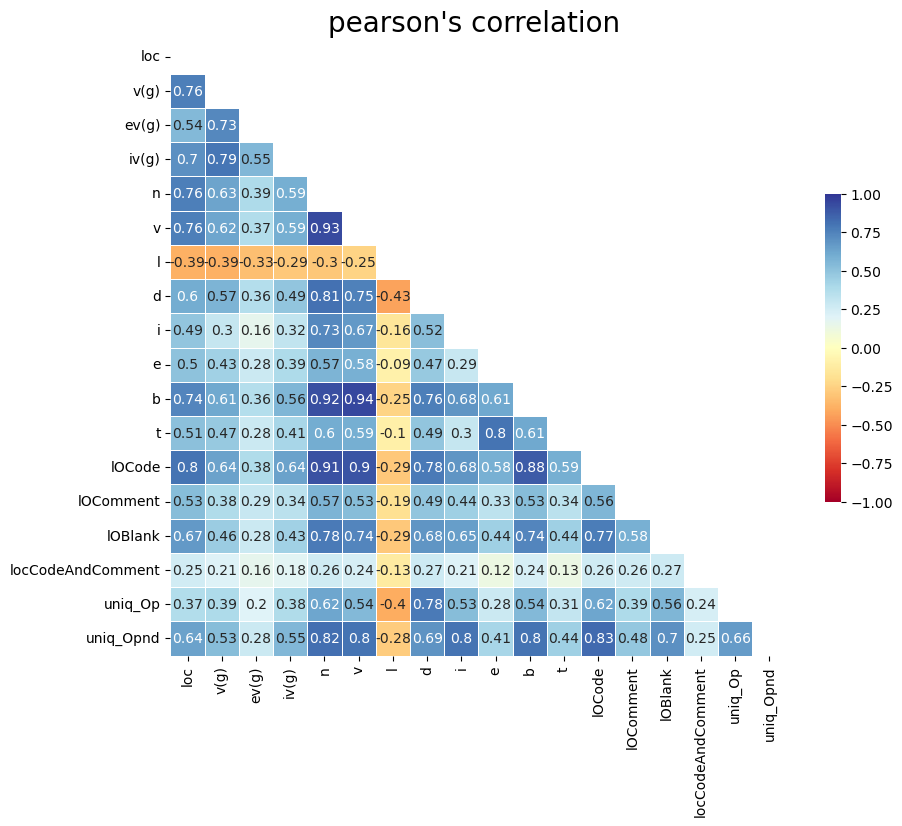

In [62]:
def triangle_heatmap(corr, square=True, annot=True, cmap='RdYlBu', ax=None, cbar=True):
    # 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, square=square, annot=annot, linewidths=0.5,
                mask=mask,                 # 표시하지 않을 마스크
                cmap=cmap,                 # Red, Yellow, Blue 색상으로 표시
                ax=ax,
                vmin = -1,vmax = 1,        # 컬러바 범위
                cbar_kws={"shrink": .5},   # 컬러바 크기
                cbar=cbar,               )
plt.figure(figsize=(10, 8))
triangle_heatmap(vif_df.corr().round(2))
plt.title("pearson's correlation ", fontsize=20)
plt.show()

# decision tree
## feature importance

In [63]:
from sklearn.model_selection import train_test_split

X = train_origin_df.drop(columns='defects')
y = train_origin_df['defects']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=61, stratify=y)

In [64]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth=5, criterion='gini')
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

In [65]:
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score

# valid Acc
y_pred_valid = model.predict(X_valid)
cm_test = confusion_matrix(y_valid, y_pred_valid)
print('test Confusion Matrix')
print(cm_test)
print(f'test ACC : {(cm_test[0, 0] + cm_test[1, 1]) / cm_test.sum()}')
print(f'test f1-score : {f1_score(y_valid, y_pred_valid)}')
print(f'test roc auc score : {roc_auc_score(y_valid, y_pred_valid)}')

test Confusion Matrix
[[14591  1149]
 [ 2661  1952]]
test ACC : 0.8128040092369675
test f1-score : 0.5060928182525278
test roc auc score : 0.6750766162474924


In [66]:
feature_map = pd.DataFrame(sorted(zip(model.feature_importances_, X.columns), reverse=True), columns=['Score', 'Feature'])
print(feature_map)

       Score            Feature
0   0.956304                loc
1   0.016241            lOBlank
2   0.011085          uniq_Opnd
3   0.003267                  l
4   0.002594           total_Op
5   0.002024                  d
6   0.001865                  v
7   0.001776        branchCount
8   0.001502            uniq_Op
9   0.000859             lOCode
10  0.000734                  e
11  0.000643               v(g)
12  0.000629              iv(g)
13  0.000476                  b
14  0.000000         total_Opnd
15  0.000000                  t
16  0.000000                  n
17  0.000000  locCodeAndComment
18  0.000000          lOComment
19  0.000000                  i
20  0.000000              ev(g)


# new feature & outlier 처리

In [67]:
X = train_df.iloc[:, :-1].copy()

In [68]:
def show_outlier(df, y, features):
    plt.figure(figsize=(8,2*len(features)))
    grid = gridspec.GridSpec(len(features),2)
    plt.subplots_adjust(wspace=0.2, hspace=0.4)

    for idx, feature in enumerate(features):
        threshold = outlier_score(df, feature)

        feature_outlier = (df[feature]>threshold)*1
        ax0 = plt.subplot(grid[idx*2])
        ax1 = plt.subplot(grid[idx*2+1])
        sns.boxplot(data=df, y=feature, ax=ax0)
        sns.barplot(x=feature_outlier, y=y, ax=ax1)

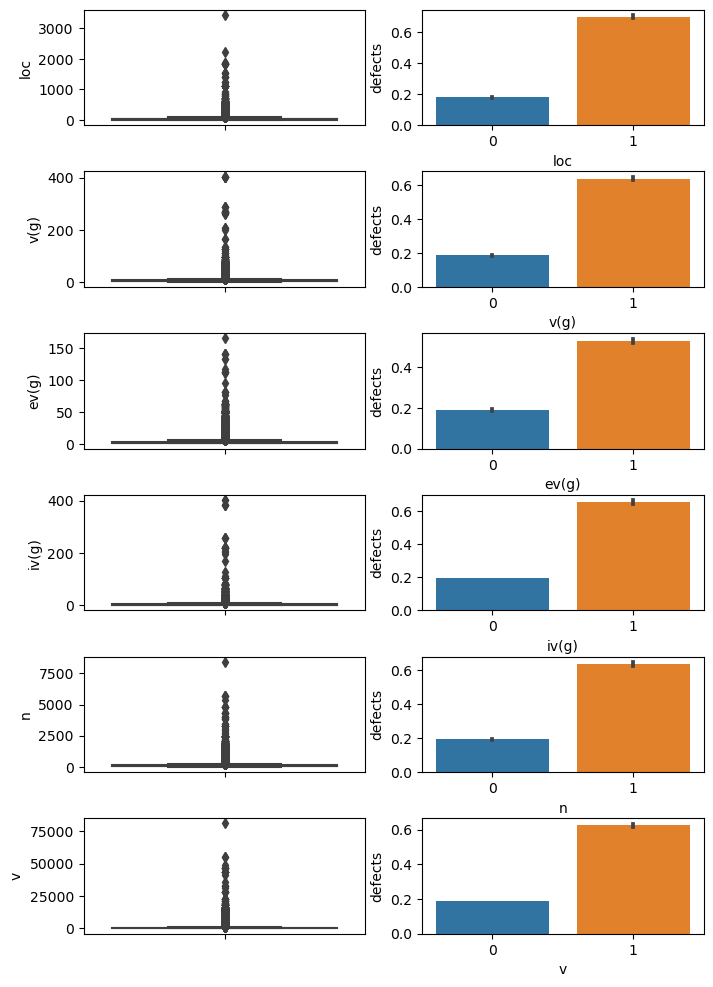

In [69]:
show_outlier(X, train_df['defects'], train_df.columns[:6])

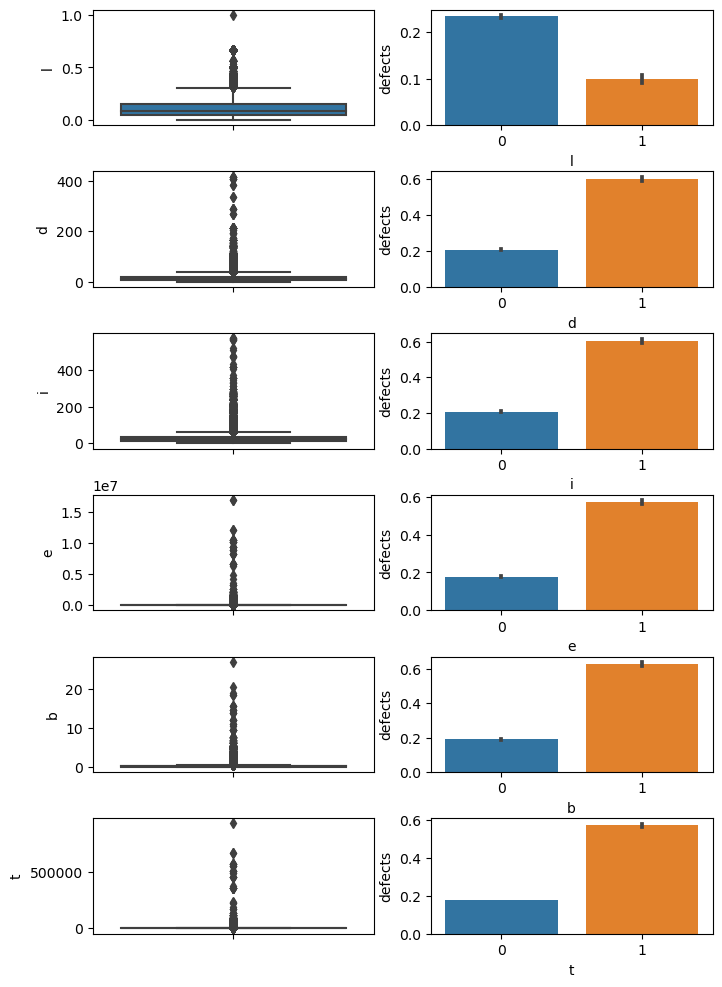

In [70]:
show_outlier(X, train_df['defects'], train_df.columns[6:12])

In [71]:
train_df.columns

Index(['loc', 'v(g)', 'ev(g)', 'iv(g)', 'n', 'v', 'l', 'd', 'i', 'e', 'b', 't',
       'lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment', 'uniq_Op',
       'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount', 'defects'],
      dtype='object')

In [122]:
def show_outlier(df1, df2, feature_names):
    plt.figure(figsize=(10,2*len(feature_names)))
    grid = gridspec.GridSpec(len(feature_names),2)
    plt.subplots_adjust(wspace=0.2, hspace=0.4)

    for idx,feature_name in enumerate(feature_names):
        ax0 = plt.subplot(grid[2*idx])
        ax1 = plt.subplot(grid[2*idx+1])
        sns.boxplot(data=df1, y=feature_name, ax=ax0)
        sns.boxplot(data=df2, y=feature_name, ax=ax1)

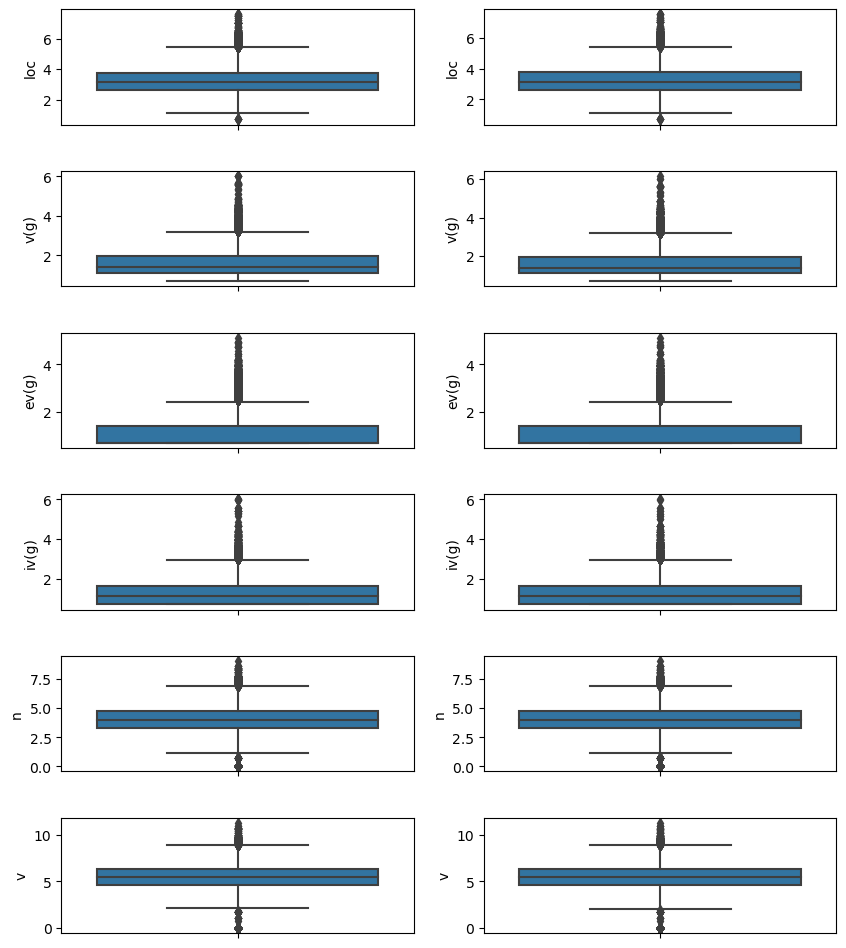

In [123]:
show_outlier(train_df, test_df, train_df.columns[:6])

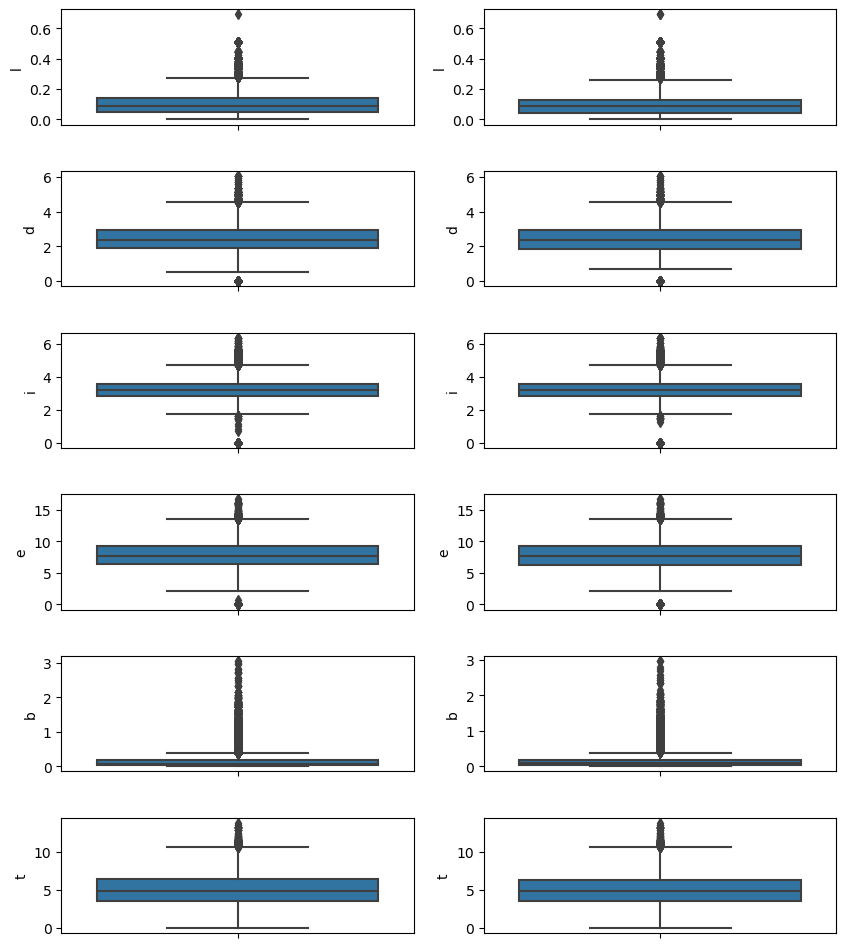

In [124]:
show_outlier(train_df, test_df, train_df.columns[6:12])

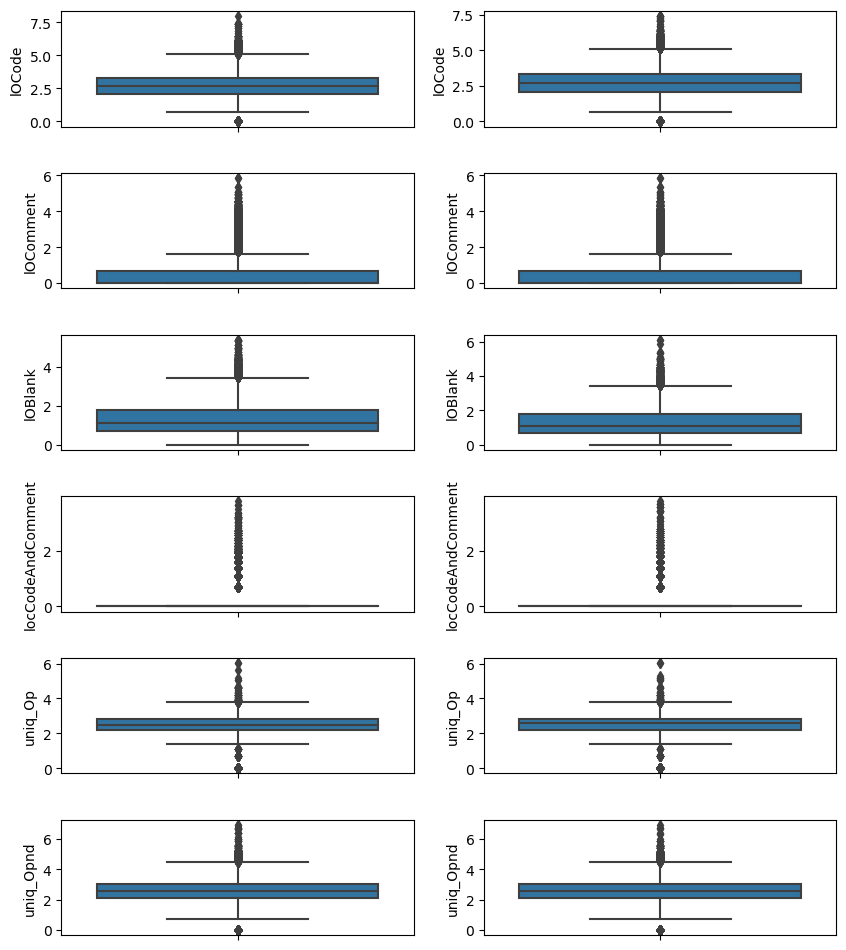

In [125]:
show_outlier(train_df, test_df, train_df.columns[12:18])

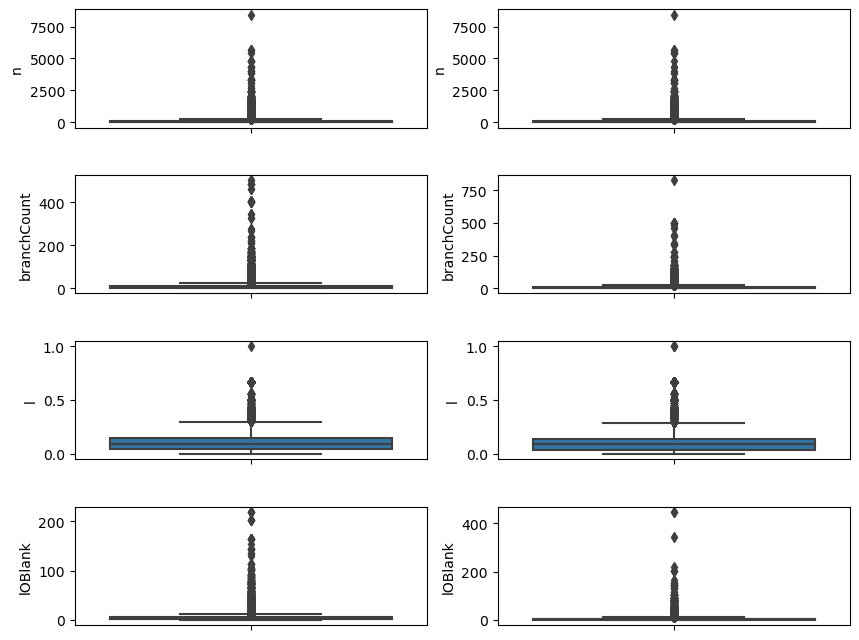

In [76]:
show_outlier(train_df[['n','branchCount', 'l', 'lOBlank']], test_df, ['n','branchCount', 'l', 'lOBlank'])

In [77]:
mask1 = train_df['loc']>=2000
train_df.loc[mask1, 'loc'] = 2000
train_df[mask1]

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
id,,,,,,,,,,,,,,,,,,,,,
63950,2000.0,286.0,113.0,385.0,8441.0,46943.69,0.0,384.45,210.28,10100866.90,...,2824,157,106,0,155.0,609.0,5420.0,3021.0,1.0,False
96949,2000.0,71.0,1.0,20.0,4828.0,46943.69,0.0,290.15,71.69,849575.36,...,1739,78,102,3,49.0,210.0,3368.0,2526.0,133.0,True


In [78]:
mask2 = train_df['b']>=20
train_df.loc[mask2, 'b']=20
train_df[mask2]

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
id,,,,,,,,,,,,,,,,,,,,,
12136,1824.0,24.0,10.0,8.0,609.0,46943.69,0.02,215.17,206.05,16846621.12,...,1588,13,106,1,27.0,55.0,3368.0,2537.0,47.0,True
20792,519.0,94.0,16.0,34.0,2656.0,15427.18,0.00,418.20,218.17,8255889.43,...,470,67,114,0,30.0,162.0,1153.0,925.0,187.0,True


In [79]:
mask3 = train_df['total_Opnd']>=2600
train_df.loc[mask3, 'total_Opnd'] = 2600
train_df[mask3]

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
id,,,,,,,,,,,,,,,,,,,,,
63950,2000.0,286.0,113.0,385.0,8441.0,46943.69,0.00,384.45,210.28,10100866.90,...,2824,157,106,0,155.0,609.0,5420.0,2600.0,1.0,False
91241,522.0,9.0,1.0,7.0,704.0,55140.81,0.01,158.71,293.29,859517.12,...,480,12,15,0,29.0,1026.0,2154.0,2600.0,17.0,True


In [80]:
def figure_target_ratio_count(df, column_name, t0,t1,t2,t3, ax0=None, ax1=None, target_name='defects', debug=False):

    if not ax0:
        plt.figure(figsize=(12,2))
        grid = gridspec.GridSpec(1,2)
        ax0, ax1 = plt.subplot(grid[0]), plt.subplot(grid[1])
    if debug:
        print('{0:0.3f} {1:0.3f} {2:0.3f}'.format(
            df.loc[df[column_name]<=t1, target_name].mean(),
            df.loc[(t1<df[column_name]) & (df[column_name]<=t2), target_name].mean(),
            df.loc[t2<df[column_name], target_name].mean()
        ))
    sns.barplot(data=df, x=df[column_name].apply(lambda l:  0 if l<=t0 else 1 if l<=t1 else 2 if l<=t2 else 3 if l<=t3 else 4), y=target_name, ax=ax0)
    sns.countplot(x=df[column_name].apply(lambda l:  0 if l<=t0 else 1 if l<=t1 else 2 if l<=t2 else 3 if l<=t3 else 4), ax=ax1)
    return t0,t1,t2,t3

loc 11.0 22.0 37.54085080038914 85.5
v(g) 2.0 3.0 5.51939506500398 12.0
ev(g) 1.0 1.9250464314141682 2.8500928628283364 6.0
iv(g) 2.0 2.7567907785737447 3.5135815571474898 8.5
n 0.0 51.0 97.28246808761534 240.0
v 0.0 232.79 542.3375727484449 1255.44
l 0.0 0.09 0.11158863241060109 0.3
d 0.0 9.82 13.71411740809528 36.644999999999996
i 0.0 23.28 27.597954800860823 62.38499999999999
e 0.0 2265.87 21377.881945225672 24551.305
b 0.0 0.08 0.18028460245865394 0.43
t 0.0 125.91 1172.287592924737 1363.9699999999998
lOCode 0 14.0 22.934241325432623 54.5
lOComment 0 0.8986822322455116 1.7973644644910232 2.5
lOBlank 0 2.0 3.9962147342354295 11.0
locCodeAndComment 0 0.09914802040034197 0.19829604080068394 0.0
uniq_Op 0.0 11.0 11.901588986173756 28.0
uniq_Opnd 0.0 12.0 15.629350549806905 39.5
total_Op 0.0 30.0 57.90695439403319 142.5
total_Opnd 0.0 20.0 39.48295745998054 95.0
branchCount 3.0 5.0 9.898098523038826 23.0


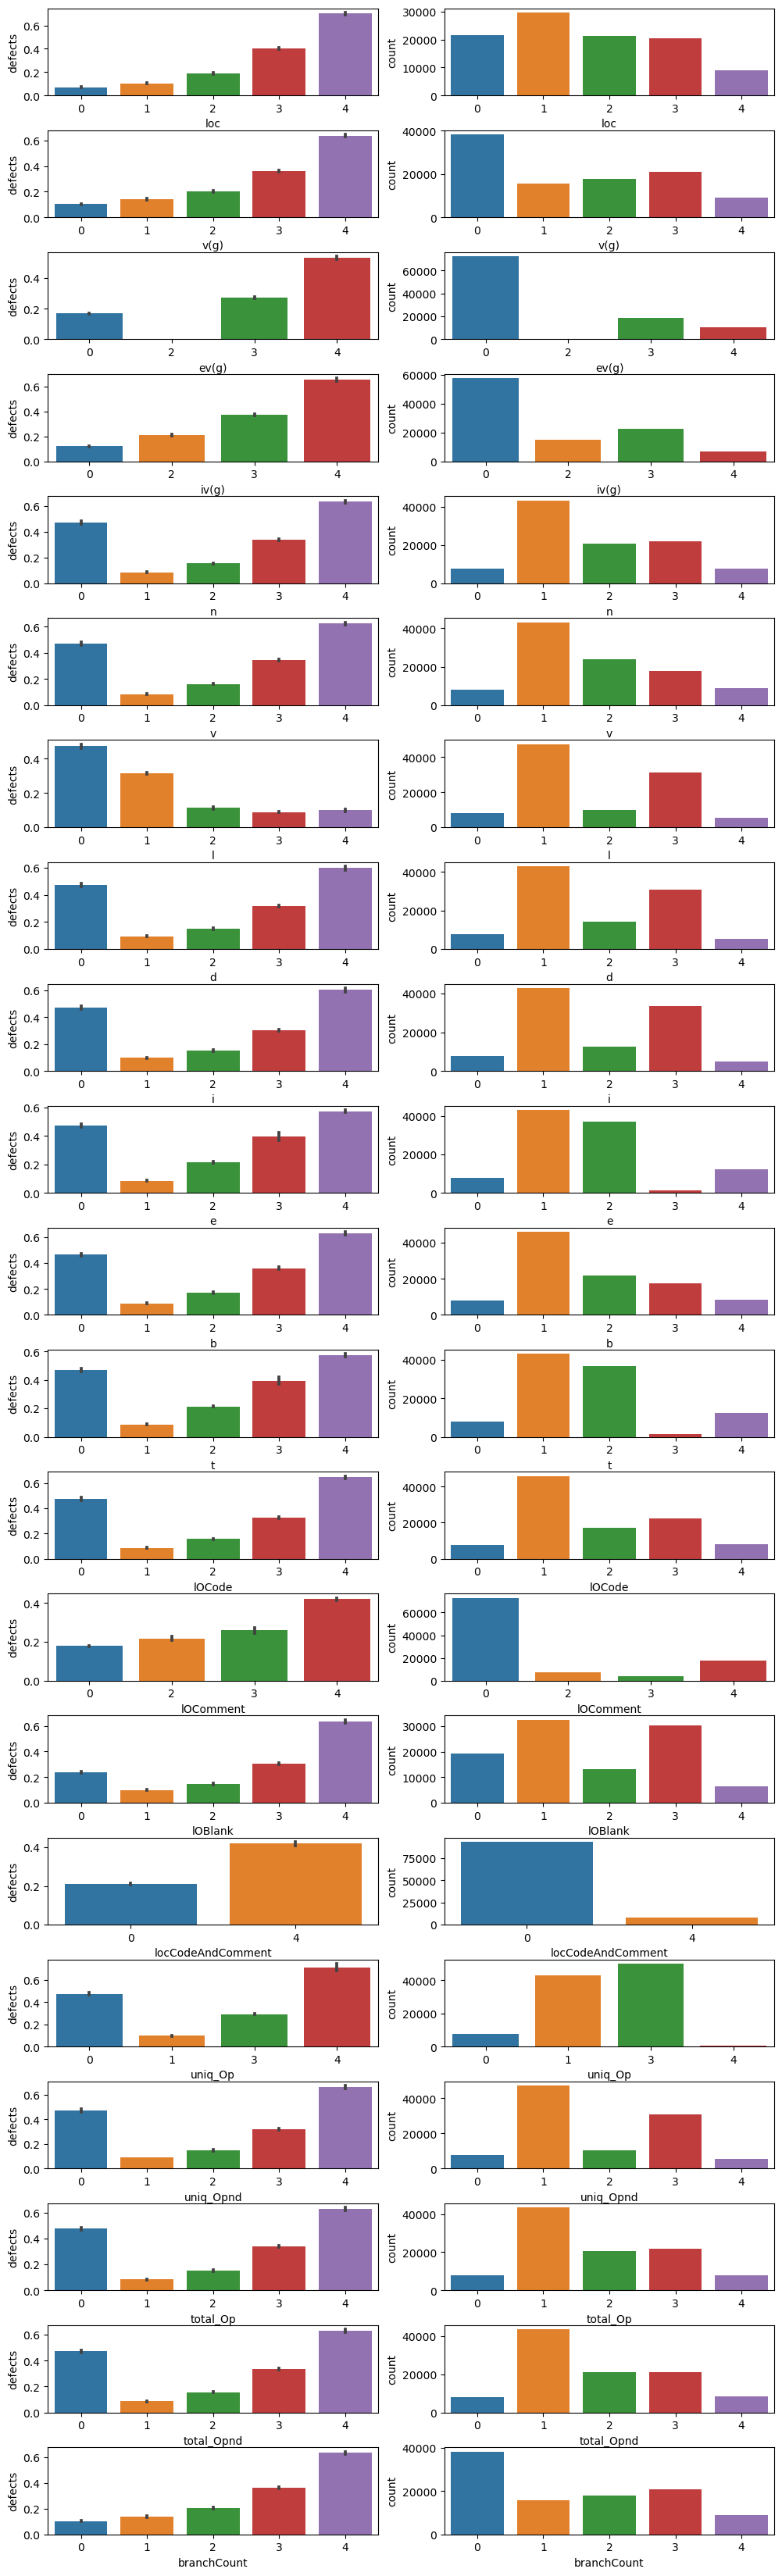

In [81]:
column_names = train_df.drop(columns='defects').columns
all_df = pd.concat([train_df.drop(columns='defects'), test_df])
plt.figure(figsize=(12,2*len(column_names)))
grid = gridspec.GridSpec(1*len(column_names),2)
for idx, column_name in enumerate(column_names):
    t0 = all_df[column_name].mode()[0]
    t1 = all_df[column_name].median()
    t2 = all_df[column_name].mean()
    t3 = outlier_score(all_df, column_name)
    if t1==0 or t0>=t1:
        t1 = (t0+all_df[column_name].mean()) / 2
    print(column_name, t0, t1,t2,t3)

    plt.subplots_adjust(wspace=0.2, hspace=0.4)
    ax0, ax1 = plt.subplot(grid[idx*2]), plt.subplot(grid[idx*2+1])
    figure_target_ratio_count(train_df, column_name, t0,t1,t2,t3, ax0, ax1)

In [82]:
def generate_seperate_index(df, column_name):
    t0 = df[column_name].mode()[0]
    t1 = df[column_name].median()
    t2 = df[column_name].mean()
    t3 = outlier_score(df, column_name)
    if t1==0 or t0>=t1:
        t1 = (t0+df[column_name].mean()) / 2
    return t0,t1,t2,t3

In [83]:
outlier_columns = ['lOBlank', 'branchCount']
category_columns = set(outlier_columns)

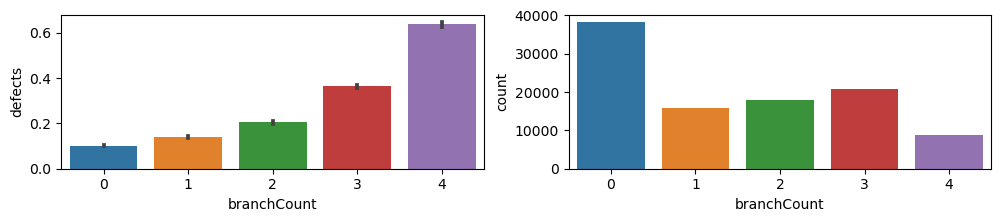

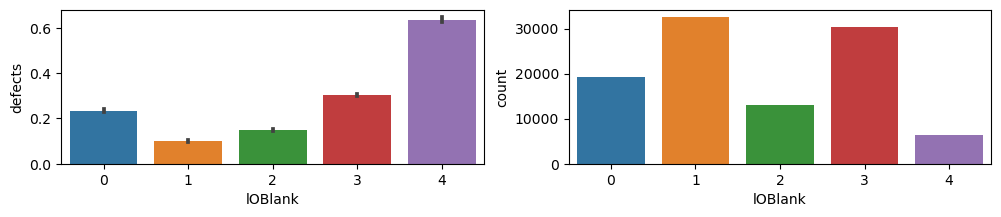

In [84]:
for category_column in category_columns:
    t0,t1,t2,t3 = figure_target_ratio_count(train_df, category_column, *generate_seperate_index(all_df, category_column))
    train_df[category_column+'_n'] = train_df[category_column].apply(lambda l:  0 if l<=t0 else 1 if l<=t1 else 2 if l<=t2 else 3 if l<=t3 else 4)
    test_df[category_column+'_n'] = test_df[category_column].apply(lambda l:  0 if l<=t0 else 1 if l<=t1 else 2 if l<=t2 else 3 if l<=t3 else 4)

In [85]:
train_df.columns

Index(['loc', 'v(g)', 'ev(g)', 'iv(g)', 'n', 'v', 'l', 'd', 'i', 'e', 'b', 't',
       'lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment', 'uniq_Op',
       'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount', 'defects',
       'branchCount_n', 'lOBlank_n'],
      dtype='object')

In [86]:
resume_table(train_df)

,Dtypes,결측치,유니크개수,평균,std,min,median,max,outlier
Column,,,,,,,,,
loc,float64,0,377,37.330788,53.814623,1.0,22.00,2000.00,85.500
v(g),float64,0,106,5.492684,7.900855,1.0,3.00,404.00,12.000
ev(g),float64,0,71,2.845022,4.631262,1.0,1.00,165.00,6.000
iv(g),float64,0,84,3.498826,5.534541,1.0,2.00,402.00,8.500
n,float64,0,836,96.655995,171.147191,0.0,51.00,8441.00,240.000
v,float64,0,4515,538.280956,1270.791601,0.0,232.79,80843.08,1254.120
l,float64,0,55,0.111634,0.100096,0.0,0.09,1.00,0.300
d,float64,0,3360,13.681881,14.121306,0.0,9.82,418.20,36.600
i,float64,0,5171,27.573007,22.856742,0.0,23.36,569.78,62.510


In [87]:
train_df.describe()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,branchCount_n,lOBlank_n
count,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,1.017630e+05,...,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000
mean,37.330788,5.492684,2.845022,3.498826,96.655995,538.280956,0.111634,13.681881,27.573007,2.085359e+04,...,1.773945,3.979865,0.196604,11.896131,15.596671,57.628116,39.241424,9.839549,1.471252,1.725499
std,53.814623,7.900855,4.631262,5.534541,171.147191,1270.791601,0.100096,14.121306,22.856742,1.905714e+05,...,5.902412,6.382358,0.998906,6.749549,18.064261,104.537660,71.371754,14.412769,1.390849,1.247572
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,13.000000,2.000000,1.000000,1.000000,25.000000,97.670000,0.050000,5.600000,15.560000,5.647300e+02,...,0.000000,1.000000,0.000000,8.000000,7.000000,15.000000,10.000000,3.000000,0.000000,1.000000
50%,22.000000,3.000000,1.000000,2.000000,51.000000,232.790000,0.090000,9.820000,23.360000,2.256230e+03,...,0.000000,2.000000,0.000000,11.000000,12.000000,30.000000,20.000000,5.000000,1.000000,1.000000
75%,42.000000,6.000000,3.000000,4.000000,111.000000,560.250000,0.150000,18.000000,34.340000,1.019324e+04,...,1.000000,5.000000,0.000000,16.000000,20.000000,66.000000,45.000000,11.000000,3.000000,3.000000
max,2000.000000,404.000000,165.000000,402.000000,8441.000000,80843.080000,1.000000,418.200000,569.780000,1.684662e+07,...,344.000000,219.000000,43.000000,410.000000,1026.000000,5420.000000,2600.000000,503.000000,4.000000,4.000000


# 평균을 통한 새로운 피처 생성

In [111]:
def add_feat(df):
    df['mean_bnv']         = (df['n'] + df['v'] + df['b']) /3;
    df['mean_uniqOpOpend'] = (df['uniq_Op'] + df['uniq_Opnd']) /2;
    df['mean_totOpOpend']  = (df['total_Op'] + df['total_Opnd']) /2;
    df['mean_brcntvg']     = (df['branchCount'] + df['v(g)']) / 2;

In [112]:
add_feat(train_df)
add_feat(test_df)

(0.0, 94.81, 211.70534745765488, 499.72166666666675)

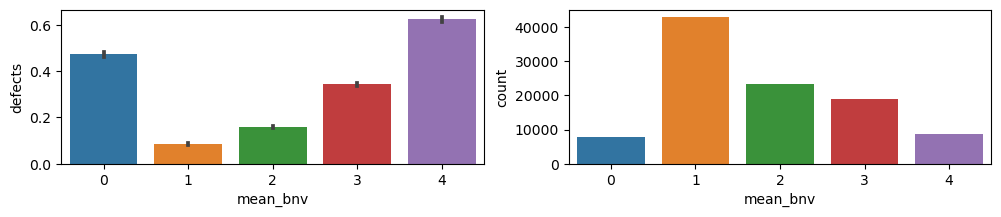

In [113]:
figure_target_ratio_count(train_df, 'mean_bnv', *generate_seperate_index(train_df, 'mean_bnv'))

(0.0, 11.5, 13.746400951229818, 32.5)

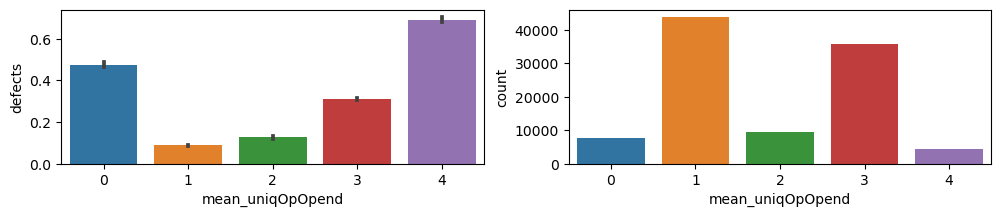

In [114]:
figure_target_ratio_count(train_df, 'mean_uniqOpOpend', *generate_seperate_index(train_df, 'mean_uniqOpOpend'))

(2.5, 4.0, 7.666116368424673, 17.5)

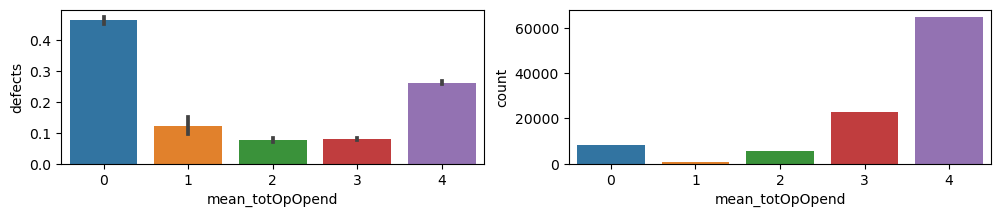

In [117]:
figure_target_ratio_count(train_df, 'mean_totOpOpend', *generate_seperate_index(train_df, 'mean_brcntvg'))

(2.5, 4.0, 7.666116368424673, 17.5)

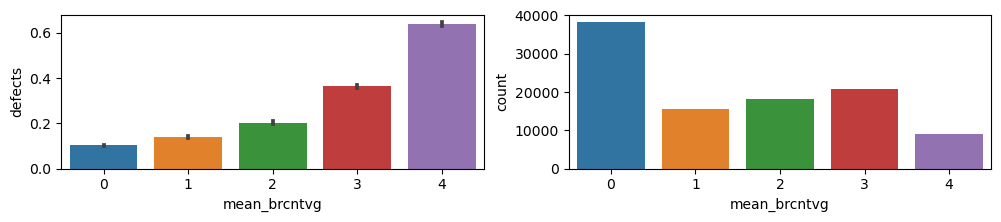

In [118]:
figure_target_ratio_count(train_df, 'mean_brcntvg', *generate_seperate_index(train_df, 'mean_brcntvg'))

# 주요 feature를 뽑은 후 outlier 여부로 유니크 값 생성

In [90]:
def outlier_count(df1, df2, columns):
    all_df = pd.concat([df1, df2])
    outlier_df = pd.DataFrame(columns=['mix_outlier'])
    is_first_feature = True
    for feature in columns:
        threshold = outlier_score(all_df, feature)
        if is_first_feature:
            outlier_df['mix_outlier'] = all_df[feature].apply(lambda x: 1 if x>threshold else 0).astype(str)+'_'
            is_first_feature=False
        else:
            outlier_df['mix_outlier'] += all_df[feature].apply(lambda x: 1 if x>threshold else 0).astype(str)+'_' # 0_1_1_
    val_counts_dict = outlier_df['mix_outlier'].value_counts().to_dict() #{'0_1_1_':300, '1_1_1_':500}
    pure_1th_val = sorted(val_counts_dict.items(), key = lambda item: item[1], reverse = True)[0][0]
    pure_2th_val = sorted(val_counts_dict.items(), key = lambda item: item[1], reverse = True)[1][0]
    pure_3th_val = sorted(val_counts_dict.items(), key = lambda item: item[1], reverse = True)[2][0]
    pure_4th_val = sorted(val_counts_dict.items(), key = lambda item: item[1], reverse = True)[3][0]
    print(f'1th : {pure_1th_val}:{val_counts_dict[pure_1th_val]}\n2th : {pure_2th_val}:{val_counts_dict[pure_2th_val]}\n3th : {pure_3th_val}:{val_counts_dict[pure_3th_val]}\n4th : {pure_4th_val}:{val_counts_dict[pure_4th_val]}')
    all_df['pure'] = outlier_df['mix_outlier'].apply(lambda x: 0 if x==pure_1th_val else 1 if x==pure_2th_val else 2 if x==pure_3th_val else 3 if x==pure_4th_val else 4)

    return all_df[:df1.shape[0]], all_df[df1.shape[0]:].dropna(axis=1)

In [91]:
feature_map

,Score,Feature
0,0.956304,loc
1,0.016241,lOBlank
2,0.011085,uniq_Opnd
3,0.003267,l
4,0.002594,total_Op
5,0.002024,d
6,0.001865,v
7,0.001776,branchCount
8,0.001502,uniq_Op
9,0.000859,lOCode


In [92]:
importance_features = feature_map.loc[feature_map['Score']>0.0001, 'Feature']
train_df, test_df = outlier_count(train_df, test_df, importance_features)

1th : 0_0_0_0_0_0_0_0_0_0_0_0_0_0_:129950
2th : 0_0_0_1_0_0_0_0_0_0_0_0_0_0_:8667
3th : 0_0_0_0_0_0_0_0_0_0_1_0_0_0_:2766
4th : 1_0_0_0_0_0_0_1_0_0_0_1_1_0_:2216


In [93]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101763 entries, 0 to 101762
Data columns (total 25 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   loc                101763 non-null  float64
 1   v(g)               101763 non-null  float64
 2   ev(g)              101763 non-null  float64
 3   iv(g)              101763 non-null  float64
 4   n                  101763 non-null  float64
 5   v                  101763 non-null  float64
 6   l                  101763 non-null  float64
 7   d                  101763 non-null  float64
 8   i                  101763 non-null  float64
 9   e                  101763 non-null  float64
 10  b                  101763 non-null  float64
 11  t                  101763 non-null  float64
 12  lOCode             101763 non-null  int64  
 13  lOComment          101763 non-null  int64  
 14  lOBlank            101763 non-null  int64  
 15  locCodeAndComment  101763 non-null  int64  
 16  uniq_Op

In [94]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 67842 entries, 101763 to 169604
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   loc                67842 non-null  float64
 1   v(g)               67842 non-null  float64
 2   ev(g)              67842 non-null  float64
 3   iv(g)              67842 non-null  float64
 4   n                  67842 non-null  float64
 5   v                  67842 non-null  float64
 6   l                  67842 non-null  float64
 7   d                  67842 non-null  float64
 8   i                  67842 non-null  float64
 9   e                  67842 non-null  float64
 10  b                  67842 non-null  float64
 11  t                  67842 non-null  float64
 12  lOCode             67842 non-null  int64  
 13  lOComment          67842 non-null  int64  
 14  lOBlank            67842 non-null  int64  
 15  locCodeAndComment  67842 non-null  int64  
 16  uniq_Op            67

<Axes: xlabel='pure', ylabel='count'>

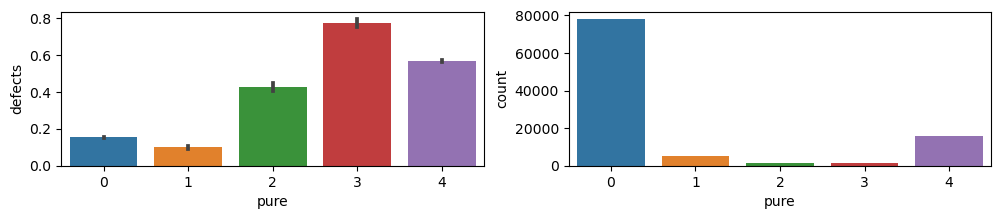

In [95]:
plt.figure(figsize=(12,2))
grid = gridspec.GridSpec(1,2)
plt.subplots_adjust(wspace=0.2, hspace=0.4)
ax0, ax1 = plt.subplot(grid[0]), plt.subplot(grid[1])
sns.barplot(data=train_df, x='pure', y='defects', ax=ax0)
sns.countplot(data=train_df, x='pure', ax=ax1)

In [96]:
# vif
# train_df = train_df.drop(columns=category_columns)
# test_df = test_df.drop(columns=category_columns)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101763 entries, 0 to 101762
Data columns (total 25 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   loc                101763 non-null  float64
 1   v(g)               101763 non-null  float64
 2   ev(g)              101763 non-null  float64
 3   iv(g)              101763 non-null  float64
 4   n                  101763 non-null  float64
 5   v                  101763 non-null  float64
 6   l                  101763 non-null  float64
 7   d                  101763 non-null  float64
 8   i                  101763 non-null  float64
 9   e                  101763 non-null  float64
 10  b                  101763 non-null  float64
 11  t                  101763 non-null  float64
 12  lOCode             101763 non-null  int64  
 13  lOComment          101763 non-null  int64  
 14  lOBlank            101763 non-null  int64  
 15  locCodeAndComment  101763 non-null  int64  
 16  uniq_Op

In [97]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101763 entries, 0 to 101762
Data columns (total 25 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   loc                101763 non-null  float64
 1   v(g)               101763 non-null  float64
 2   ev(g)              101763 non-null  float64
 3   iv(g)              101763 non-null  float64
 4   n                  101763 non-null  float64
 5   v                  101763 non-null  float64
 6   l                  101763 non-null  float64
 7   d                  101763 non-null  float64
 8   i                  101763 non-null  float64
 9   e                  101763 non-null  float64
 10  b                  101763 non-null  float64
 11  t                  101763 non-null  float64
 12  lOCode             101763 non-null  int64  
 13  lOComment          101763 non-null  int64  
 14  lOBlank            101763 non-null  int64  
 15  locCodeAndComment  101763 non-null  int64  
 16  uniq_Op

In [98]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 67842 entries, 101763 to 169604
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   loc                67842 non-null  float64
 1   v(g)               67842 non-null  float64
 2   ev(g)              67842 non-null  float64
 3   iv(g)              67842 non-null  float64
 4   n                  67842 non-null  float64
 5   v                  67842 non-null  float64
 6   l                  67842 non-null  float64
 7   d                  67842 non-null  float64
 8   i                  67842 non-null  float64
 9   e                  67842 non-null  float64
 10  b                  67842 non-null  float64
 11  t                  67842 non-null  float64
 12  lOCode             67842 non-null  int64  
 13  lOComment          67842 non-null  int64  
 14  lOBlank            67842 non-null  int64  
 15  locCodeAndComment  67842 non-null  int64  
 16  uniq_Op            67

# save train & test

In [99]:
train_df.to_csv(data_path+'train_f7.csv', index_label='id')
test_df.to_csv(data_path+'test_f7.csv', index_label='id')

In [100]:
# f7 : 이상치 처리, test에 이상치에 있는경우 카테고리 데이터 생성, 새로운 피처 생성, drop 안함